This notebook assumes your working directory has two subfolders named `./data` and `./figures`

#### Import modules

In [1]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import os
import re

os.getcwd()
sc.set_figure_params()

sc.settings.verbosity = 0
sc.logging.print_versions()
results_file = 'data/anndata.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


#### Reading in data

In [2]:
# Reading in counts
counts = pd.read_table('data/count.axial.txt')
counts_tp = counts.transpose()
counts_tp.to_csv('data/count.axial.transpose.txt', sep = '\t')

adata = sc.read('data/count.axial.transpose.txt')
meta = pd.read_table('data/meta.axial.txt')

# https://anndata.readthedocs.io/
np.where(meta.index.values != adata.obs.index.values)
np.where(meta.index.values == adata.obs.index.values)

adata.obs = meta
rcParams['figure.figsize'] = (10, 20)
#sc.pl.highest_expr_genes(adata, n_top=20, save='.png')

#### Cell QC

... storing 'STAGE' as categorical
... storing 'GENO' as categorical
... storing 'BATCH' as categorical
... storing 'SEQ' as categorical
... storing 'SAMPLE' as categorical
... storing 'stage.nice' as categorical


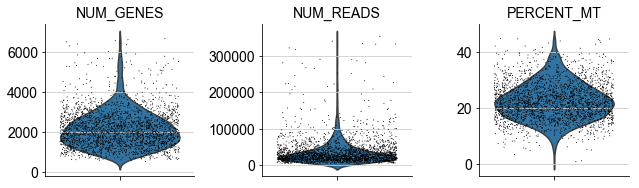

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata.obs.describe()

# Looking for mitochondrial genes in the dataset
mito_genes = adata.var_names.str.startswith('MT-')
[i for i, x in enumerate(mito_genes) if x]
adata[:,mito_genes].var.index.values

# Skip mito filtering - we'll lose too many cells
mito_QC = False
if mito_QC:
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1).A1
    adata.obs['n_counts'] = adata.X.sum(axis=1)

sc.pl.violin(adata, ['NUM_GENES', 'NUM_READS', 'PERCENT_MT'],
            jitter=0.4, multi_panel=True, save = '.png')

# Removing cells with greater than 4k genes
adata = adata[adata.obs['NUM_GENES'] < 4000, :]

#### Gene QC/normalization

In [4]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
sc.pp.scale(adata, max_value=10)

Trying to set attribute `.obs` of view, making a copy.
/Users/info/miniconda3/envs/scanpy-env/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


#### Linear dimensional reduction (PCA)

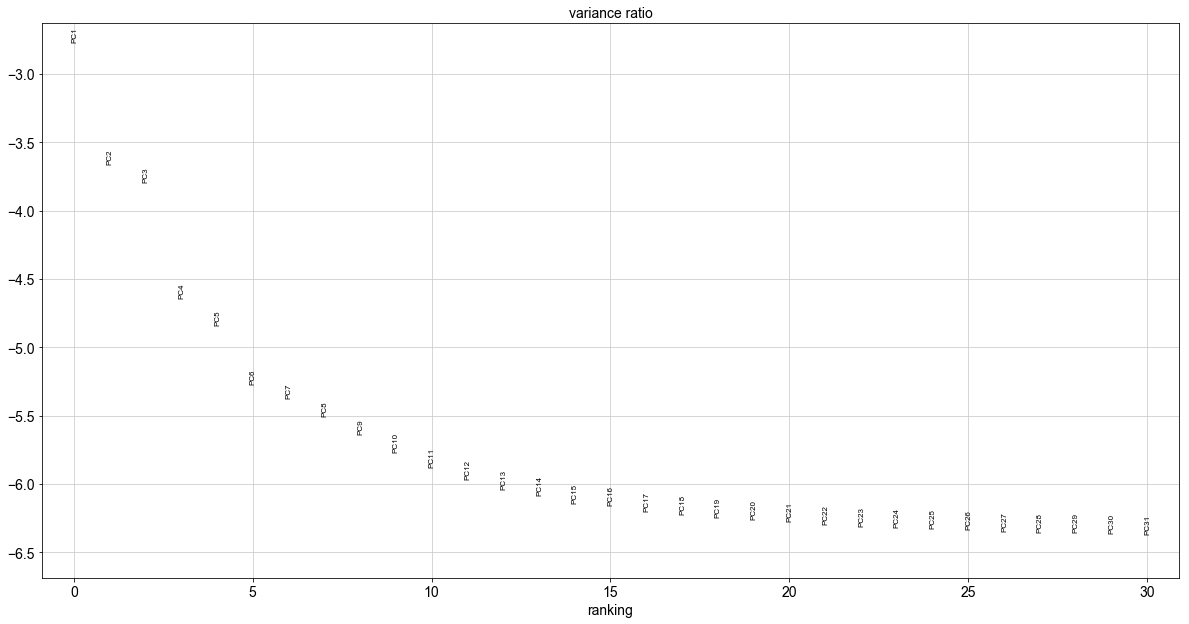

In [12]:
sc.tl.pca(adata, svd_solver='arpack')
#sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write(results_file)

plt.rcParams["figure.figsize"] = (20,30)

#### Clustering and non-linear dimensional reduction (UMAP)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=12)
sc.tl.umap(adata, n_components = 2)
sc.tl.louvain(adata, resolution = 0.4)

adata.write(results_file)
sc.pl.umap(adata, components='all', color=['louvain'], save = '.png')


plt.rcParams["figure.figsize"] = (10,10)


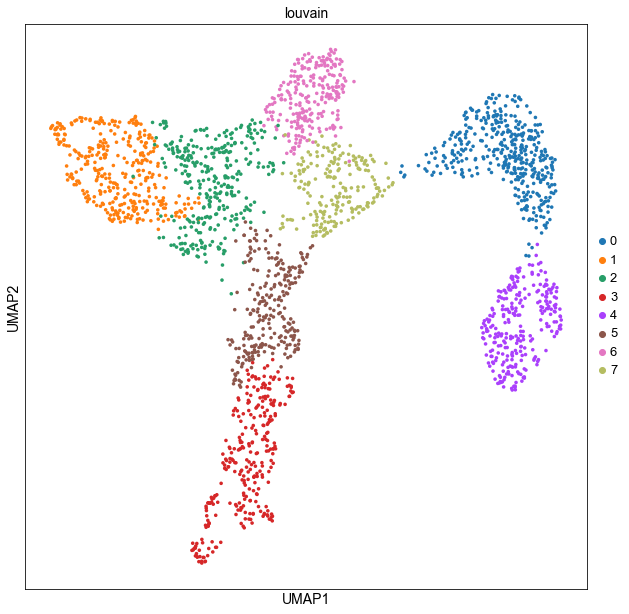

In [23]:
plt.rcParams["figure.figsize"] = (10,10)
sc.pl.umap(adata, components='all', color=['louvain'], save = '.png')

#### Differential expression

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg',)
plt.rcParams["figure.figsize"] = (20,30)
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, fontsize= 50,save = 'logreg.png')

Diff_Genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
Diff_Genes.to_csv(path_or_buf='./figures/Diff_Genes.csv')


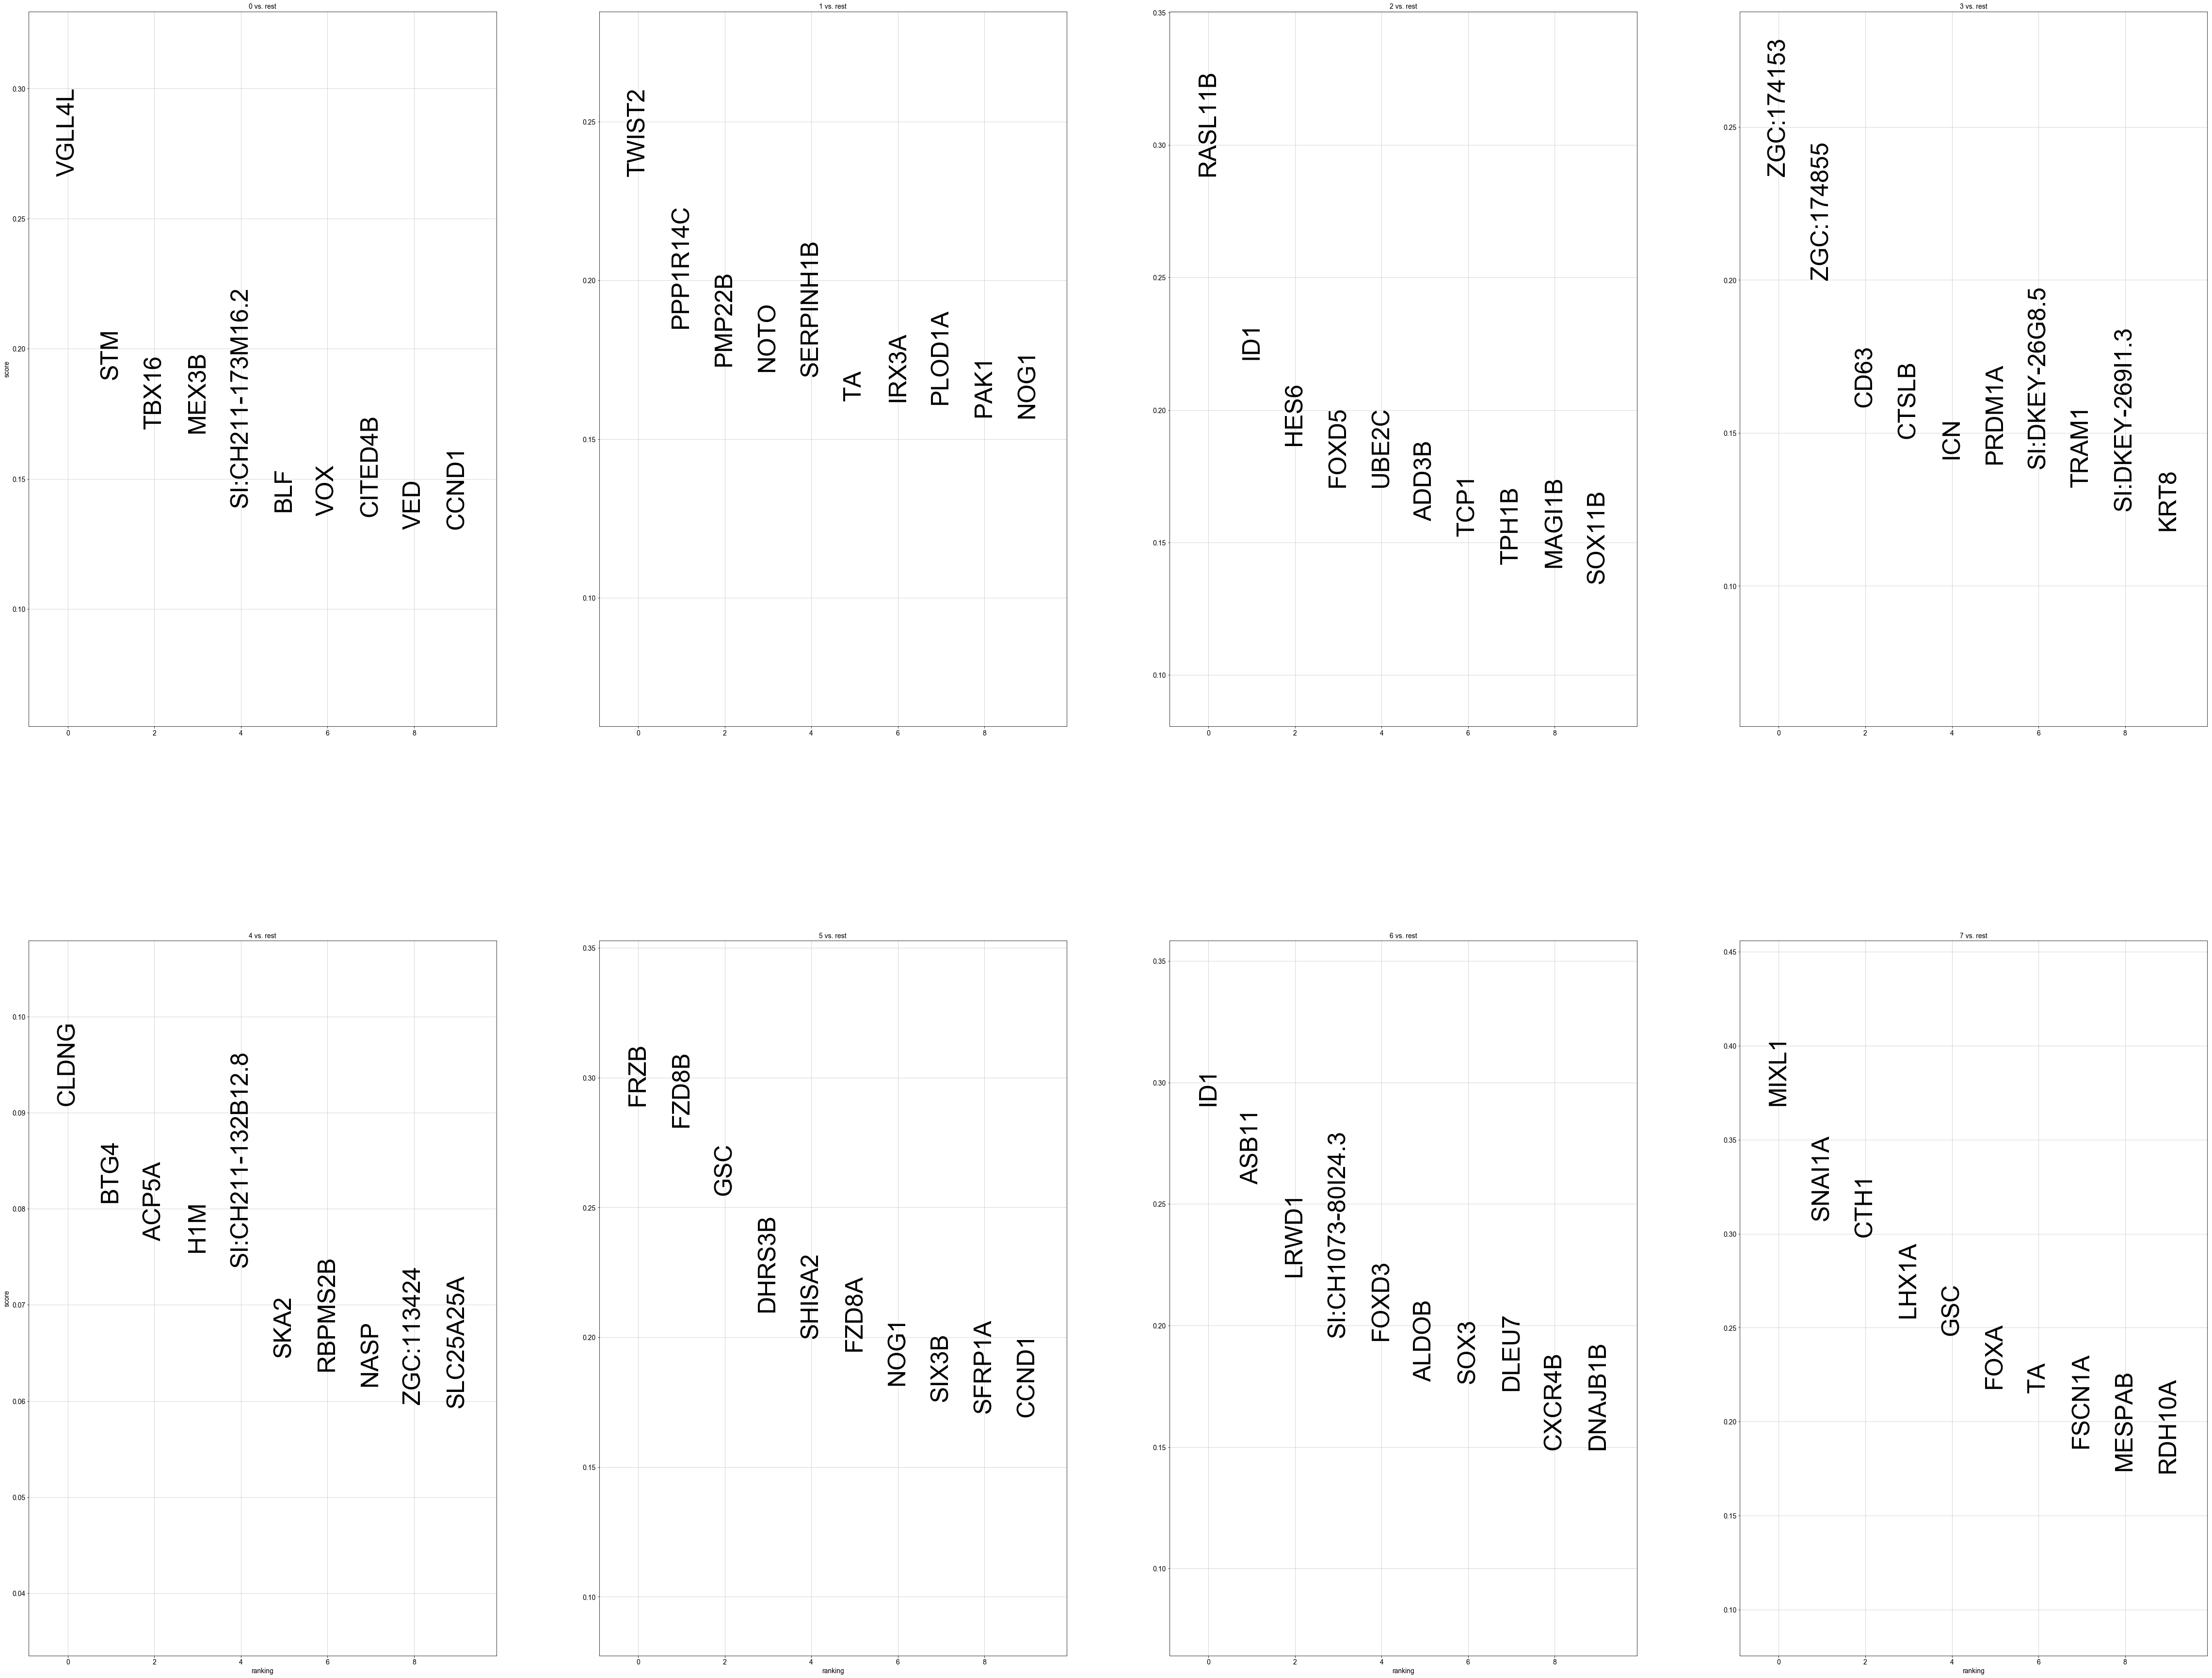

In [25]:
plt.rcParams["figure.figsize"] = (20,30)
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False, fontsize= 50,save = 'logreg.png')

#### Exporting expression and meta for app

In [8]:
# Pull out umap coordinates
coordinates = adata.obsm["X_umap"]

# Converting to pandas dataframe
coordinate_df = pd.DataFrame(coordinates)
metadata = adata.obs

# Setting row names and writing meta data to a csv file
coordinate_df = coordinate_df.set_index(metadata.index.values)
combined = metadata.join(coordinate_df)
combined.to_csv(path_or_buf='./data/combined.csv')

# Grabbing row and column names for expression matrix
cell_names = adata.obs.index
gene_names = adata.var.index

# Converting expression matrix and writing to csv file
log_values_df = pd.DataFrame(adata.X, index=cell_names, columns = gene_names)
log_values_df.to_csv('./data/expression_matrix.csv')


combined

,CELL,STAGE,GENO,BATCH,SEQ,HPF,SAMPLE,NUM_READS,NUM_TRANSCRIPTS,NUM_GENES,MT_TRANSCRIPTS,PERCENT_MT,stage.nice,n_genes,n_counts,louvain,0,1
ZFDOME_WT_DS5_AAAATCAAGAGG,ZFDOME_WT_DS5_AAAATCAAGAGG,ZFDOME,WT,DS5,DS5,4.3,ZFDOME-DS5,12403,4570,1627,1249,27.33,C-DOME,1620,3321.0,0,6.475863,4.747922
ZFDOME_WT_DS5_AAATACCACCTA,ZFDOME_WT_DS5_AAATACCACCTA,ZFDOME,WT,DS5,DS5,4.3,ZFDOME-DS5,8513,3615,1361,1045,28.91,C-DOME,1351,2569.0,0,6.773664,5.650546
ZFDOME_WT_DS5_AATTATGACTCG,ZFDOME_WT_DS5_AATTATGACTCG,ZFDOME,WT,DS5,DS5,4.3,ZFDOME-DS5,11419,4352,1560,1257,28.88,C-DOME,1553,3094.0,0,7.100366,5.738555
ZFDOME_WT_DS5_ACCCGCGAGAAG,ZFDOME_WT_DS5_ACCCGCGAGAAG,ZFDOME,WT,DS5,DS5,4.3,ZFDOME-DS5,9109,3760,1420,1110,29.52,C-DOME,1411,2649.0,0,8.078839,4.524943
ZFDOME_WT_DS5_ACGAGGTCAGGN,ZFDOME_WT_DS5_ACGAGGTCAGGN,ZFDOME,WT,DS5,DS5,4.3,ZFDOME-DS5,6510,2933,1266,634,21.62,C-DOME,1260,2298.0,0,7.070120,5.752763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFHIGH_WT_DS5b_CTACTTCGTTGC,ZFHIGH_WT_DS5b_CTACTTCGTTGC,ZFHIGH,WT,DS5b,DS5,3.3,ZFHIGH-DS5b,18590,8540,3363,1177,13.78,A-HIGH,3344,7356.0,4,10.095206,-4.508259
ZFHIGH_WT_DS5b_CTATGTATGTCA,ZFHIGH_WT_DS5b_CTATGTATGTCA,ZFHIGH,WT,DS5b,DS5,3.3,ZFHIGH-DS5b,20803,5993,2136,2374,39.61,A-HIGH,2124,3618.0,4,10.168929,-5.454010
ZFHIGH_WT_DS5b_GGACTCGAGTTT,ZFHIGH_WT_DS5b_GGACTCGAGTTT,ZFHIGH,WT,DS5b,DS5,3.3,ZFHIGH-DS5b,26418,11404,3590,1791,15.71,A-HIGH,3571,9607.0,4,10.243351,-5.308674
ZFHIGH_WT_DS5b_TAAGGGGATGTT,ZFHIGH_WT_DS5b_TAAGGGGATGTT,ZFHIGH,WT,DS5b,DS5,3.3,ZFHIGH-DS5b,20607,9968,3507,1566,15.71,A-HIGH,3485,8394.0,4,9.514571,-4.349451


In [9]:
log_values_df

,ABCA1A,ABCA1B,ABCC6A,ABCG2C,ABHD10B,ABHD17AB,ABI1A,ACACA,ACAD9,ACBD6,...,ZNF609A,ZNF687B,ZNF703,ZNF750,ZNF827,ZNFL2A,ZNHIT3,ZP2,ZSWIM8,ZW10
ZFDOME_WT_DS5_AAAATCAAGAGG,-0.095291,-0.213977,-0.068847,-0.247437,1.491114,-0.115822,-0.214622,-0.078609,-0.308203,-0.181536,...,2.748027,-0.385113,-0.235461,-0.115252,-0.128183,1.572837,-0.355186,-0.127948,-0.26746,-0.296354
ZFDOME_WT_DS5_AAATACCACCTA,-0.095291,-0.213977,-0.068847,-0.247437,1.056051,-0.115822,-0.214622,-0.078609,-0.308203,-0.181536,...,-0.407263,-0.385113,-0.235461,-0.115252,-0.128183,1.845155,-0.355186,-0.127948,-0.26746,-0.296354
ZFDOME_WT_DS5_AATTATGACTCG,-0.095291,-0.213977,-0.068847,-0.247437,1.997722,-0.115822,-0.214622,-0.078609,-0.308203,-0.181536,...,-0.407263,-0.385113,-0.235461,-0.115252,-0.128183,0.957128,-0.355186,-0.127948,-0.26746,-0.296354
ZFDOME_WT_DS5_ACCCGCGAGAAG,-0.095291,-0.213977,-0.068847,-0.247437,2.168371,-0.115822,-0.214622,-0.078609,-0.308203,-0.181536,...,-0.407263,-0.385113,-0.235461,-0.115252,-0.128183,-0.796979,-0.355186,-0.127948,-0.26746,4.458622
ZFDOME_WT_DS5_ACGAGGTCAGGN,-0.095291,-0.213977,-0.068847,-0.247437,-0.855432,-0.115822,-0.214622,-0.078609,-0.308203,-0.181536,...,-0.407263,-0.385113,-0.235461,-0.115252,-0.128183,-0.796979,-0.355186,-0.127948,-0.26746,-0.296354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZFHIGH_WT_DS5b_CTACTTCGTTGC,-0.095291,-0.213977,-0.068847,-0.247437,1.386479,-0.115822,-0.214622,-0.078609,-0.308203,-0.181536,...,-0.407263,1.819659,-0.235461,-0.115252,-0.128183,0.246741,-0.355186,-0.127948,-0.26746,-0.296354
ZFHIGH_WT_DS5b_CTATGTATGTCA,-0.095291,-0.213977,-0.068847,-0.247437,0.740329,-0.115822,-0.214622,-0.078609,5.472051,-0.181536,...,-0.407263,-0.385113,-0.235461,-0.115252,-0.128183,-0.796979,-0.355186,-0.127948,-0.26746,3.734987
ZFHIGH_WT_DS5b_GGACTCGAGTTT,-0.095291,-0.213977,-0.068847,-0.247437,0.849937,-0.115822,-0.214622,-0.078609,1.889777,-0.181536,...,2.810353,1.447171,-0.235461,-0.115252,-0.128183,-0.796979,-0.355186,-0.127948,-0.26746,1.873393
ZFHIGH_WT_DS5b_TAAGGGGATGTT,-0.095291,-0.213977,-0.068847,-0.247437,0.974988,-0.115822,-0.214622,-0.078609,2.108876,-0.181536,...,1.374748,-0.385113,-0.235461,-0.115252,-0.128183,-0.796979,-0.355186,-0.127948,-0.26746,-0.296354
